In [46]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [47]:
# Enable eager execution
tf.config.run_functions_eagerly(True)

In [48]:
# Load dataset
df = pd.read_excel("Monetary Data.xlsx", sheet_name="Nilai Tukar")
df.head()

,Tahun,USD,JPY,DEM,NLG,GBP,FRH,CHF,SGD,MYR,HKD,AUD,CAD
0,2025,0,0,0,0,0,0,0,0,0,0,0,0
1,Januari,"16,259.00","10,523.63",0,0,"20,245.72",0,"17,938.99","12,045.96","3,701.14","2,086.94","10,117.19","11,276.50"
2,2024,0,0,0,0,0,0,0,0,0,0,0,0
3,Desember,"16,162.00","10,236.25",0,0,"20,332.61",0,"17,920.95","11,919.34","3,616.48","2,082.02","10,081.88","11,225.18"
4,November,"15,864.00","10,453.01",0,0,"20,067.98",0,"17,944.72","11,805.79","3,566.56","2,038.59","10,283.06","11,310.03"


# Data Cleaning

In [49]:
df = df[df["Tahun"] != 0]

In [50]:
months = ["Januari", "Februari", "Maret", "April", "Mei", "Juni", "Juli", "Agustus",
          "September", "Oktober", "November", "Desember"]

dates = []
current_year = None
for index, row in df.iterrows():
    if str(row["Tahun"]).isdigit():
        current_year = int(row["Tahun"])
    elif row["Tahun"] in months and current_year:
        month_num = months.index(row["Tahun"]) + 1
        dates.append(f"{current_year}-{month_num:02d}")
    else:
        dates.append(None)

In [51]:
df = df[df["Tahun"].isin(months)].reset_index(drop=True)
df["Date"] = dates
df.drop(columns=["Tahun"], inplace=True)
for col in df.columns[:-1]:
    df[col] = df[col].astype(str).str.replace(",", "").astype(float)
df = df[["Date"] + [col for col in df.columns if col != "Date"]]
df.head()

,Date,USD,JPY,DEM,NLG,GBP,FRH,CHF,SGD,MYR,HKD,AUD,CAD
0,2025-01,16259.0,10523.63,0.0,0.0,20245.72,0.0,17938.99,12045.96,3701.14,2086.94,10117.19,11276.50
1,2024-12,16162.0,10236.25,0.0,0.0,20332.61,0.0,17920.95,11919.34,3616.48,2082.02,10081.88,11225.18
2,2024-11,15864.0,10453.01,0.0,0.0,20067.98,0.0,17944.72,11805.79,3566.56,2038.59,10283.06,11310.03
3,2024-10,15732.0,10259.89,0.0,0.0,20464.98,0.0,18136.98,11878.14,3587.29,2024.54,10319.41,11302.94
4,2024-09,15138.0,10566.44,0.0,0.0,20237.24,0.0,17899.98,11788.35,3675.19,1946.10,10417.22,11222.07


# Split Features and Target

In [52]:
X = df.drop(columns=["HKD"])
y = df["HKD"]
X["Date"] = pd.to_datetime(X["Date"], format="%Y-%m")
train_mask = (X["Date"] >= "2001-01-01") & (X["Date"] <= "2022-12-01")
test_mask = (X["Date"] >= "2023-01-01") & (X["Date"] <= "2023-12-01")

X_train, X_test = X[train_mask].drop(columns=["Date"]), X[test_mask].drop(columns=["Date"])
y_train, y_test = y[train_mask], y[test_mask]

In [53]:
X.head()

,Date,USD,JPY,DEM,NLG,GBP,FRH,CHF,SGD,MYR,AUD,CAD
0,2025-01-01,16259.0,10523.63,0.0,0.0,20245.72,0.0,17938.99,12045.96,3701.14,10117.19,11276.50
1,2024-12-01,16162.0,10236.25,0.0,0.0,20332.61,0.0,17920.95,11919.34,3616.48,10081.88,11225.18
2,2024-11-01,15864.0,10453.01,0.0,0.0,20067.98,0.0,17944.72,11805.79,3566.56,10283.06,11310.03
3,2024-10-01,15732.0,10259.89,0.0,0.0,20464.98,0.0,18136.98,11878.14,3587.29,10319.41,11302.94
4,2024-09-01,15138.0,10566.44,0.0,0.0,20237.24,0.0,17899.98,11788.35,3675.19,10417.22,11222.07


In [76]:
len(X), len(X_train)

(289, 264)

In [77]:
y_test, y_train.head()

(13    1972.71
 14    1972.70
 15    2034.91
 16    1985.00
 17    1942.00
 18    1934.00
 19    1919.00
 20    1911.00
 21    1879.00
 22    1919.00
 23    1947.00
 24    1912.00
 Name: HKD, dtype: float64,
 25    2019.00
 26    2014.37
 27    1980.26
 28    1942.30
 29    1895.38
 Name: HKD, dtype: float64)

# Normalize Data

In [54]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [55]:
X_test_scaled

array([[0.8824184 , 0.49450766, 0.        , 0.        , 0.73777289,
        0.        , 1.11459598, 1.00758174, 0.78131047, 0.89287098,
        0.97510907],
       [0.87846192, 0.43180517, 0.        , 0.        , 0.71434432,
        0.        , 1.04210556, 0.98492438, 0.76832491, 0.83721326,
        0.91891244],
       [0.94423838, 0.45662531, 0.        , 0.        , 0.6835022 ,
        0.        , 1.04892385, 0.99665706, 0.78070397, 0.82409354,
        0.94219886],
       [0.89601879, 0.4290853 , 0.        , 0.        , 0.64144818,
        0.        , 0.99181874, 0.95319026, 0.76606498, 0.79190369,
        0.94195899],
       [0.86053412, 0.42786179, 0.        , 0.        , 0.68375928,
        0.        , 1.02387859, 0.9432522 , 0.75920578, 0.78363496,
        0.90208942],
       [0.84124629, 0.47447756, 0.        , 0.        , 0.68558027,
        0.        , 1.0199354 , 0.94930145, 0.7700361 , 0.80476616,
        0.92607599],
       [0.83419881, 0.43789458, 0.        , 0.        , 0.

# Reshape Data for RNN/LSTM

In [56]:
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

In [57]:
264 * 11

2904

In [58]:
X_test_reshaped.shape

(12, 1, 11)

# Model Configuration

In [59]:
units = 50
dropout_rate = 0.2
learning_rate = 0.001

# RNN Model

In [60]:
optimizer_rnn = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_rnn = Sequential([
    SimpleRNN(units, activation="relu", return_sequences=False, input_shape=(1, 11)),
    Dense(1)
])
model_rnn.compile(optimizer=optimizer_rnn, loss="mse")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# LSTM Model

In [61]:
optimizer_lstm = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_lstm = Sequential([
    LSTM(units, activation="relu", return_sequences=False, input_shape=(1, 11)),
    Dense(1)
])
model_lstm.compile(optimizer=optimizer_lstm, loss="mse")

# Train Models

In [62]:
# Train Models
history_rnn = model_rnn.fit(X_train_reshaped, y_train_scaled, epochs=50, batch_size=16, validation_data=(X_test_reshaped, y_test_scaled), verbose=1)
history_lstm = model_lstm.fit(X_train_reshaped, y_train_scaled, epochs=50, batch_size=16, validation_data=(X_test_reshaped, y_test_scaled), verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0083 - val_loss: 0.0014
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0014 - val_loss: 7.9101e-04
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0018 - val_loss: 1.9997e-04
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0013 - val_loss: 1.1944e-04
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0021 - val_loss: 1.4627e-04
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 8.7686e-04 - val_loss: 9.5768e-05
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0054 - val_loss: 6.4624e-05
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0020 - val_loss: 2.3176e-04
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0015 - val_loss: 2.5589e-04
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0029 - val_loss: 2.5645e-04
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0042 - val_loss: 6.2998e-05
Epoch 12/50
17/17 ━━━━━━━━━━━━

# Predictions

In [63]:
y_pred_rnn = scaler_y.inverse_transform(model_rnn.predict(X_test_reshaped))
y_pred_lstm = scaler_y.inverse_transform(model_lstm.predict(X_test_reshaped))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


# Evaluation

In [64]:
mse_rnn = np.mean((y_pred_rnn - y_test.values.reshape(-1, 1))**2)
mse_lstm = np.mean((y_pred_lstm - y_test.values.reshape(-1, 1))**2)

# Plot Results

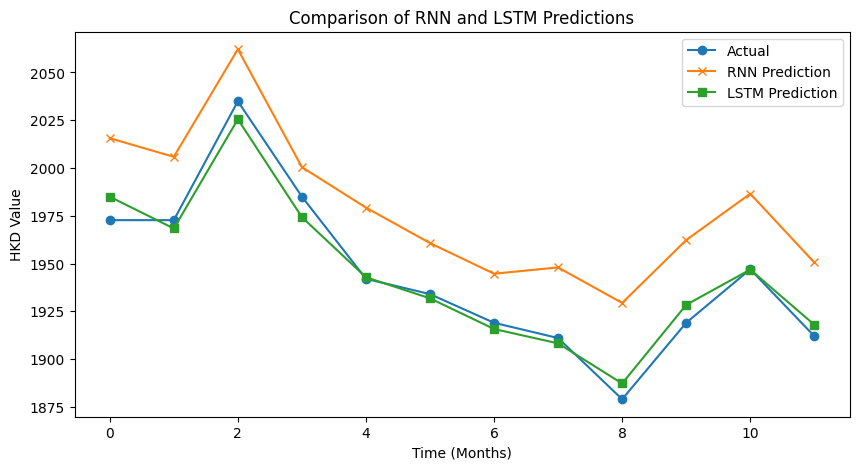

In [65]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Actual", marker='o')
plt.plot(y_pred_rnn, label="RNN Prediction", marker='x')
plt.plot(y_pred_lstm, label="LSTM Prediction", marker='s')
plt.xlabel("Time (Months)")
plt.ylabel("HKD Value")
plt.title("Comparison of RNN and LSTM Predictions")
plt.legend()
plt.show()

In [66]:
print(f"MSE RNN: {mse_rnn}")
print(f"MSE LSTM: {mse_lstm}")

MSE RNN: 1292.1136416000875
MSE LSTM: 49.04725859336663
